# Historias de la Formula 1

## Qué tan bueno es Lewis Hamilton? Explorando datos


## Just how good is Lewis Hamilton?
![title](ham.jpg)

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import time
import matplotlib
import warnings
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [2]:
df_standings = pd.read_csv("driver_standings.csv")
df_drivers = pd.read_csv("drivers.csv")
df_results = pd.read_csv("results.csv")
df_seasons = pd.read_csv("seasons.csv")
df_qualis = pd.read_csv("qualifying.csv")
df_races = pd.read_csv("races.csv")
df_circuits = pd.read_csv("circuits.csv")
df_constructors = pd.read_csv("constructors.csv")

In [49]:
df = df_results.join(df_drivers.set_index('driverId'), on='driverId', how='left', lsuffix='', rsuffix='_right')
df = df.drop(columns=['dob', 'number_right', 'nationality', 'url'])
df = df.join(df_races.set_index('raceId'), on='raceId', how='left', lsuffix='', rsuffix='_right')
df = df.drop(columns=['time_right', 'url'])
df = df.join(df_constructors.set_index('constructorId'), on='constructorId', how='left', lsuffix='', rsuffix='_right')
df = df.drop(columns=['name_right', 'nationality', 'url'])

# Preprocessing Quali Data

### Read csv and perform joins to collect everything in one dataframe 

In [50]:
df_qualis = pd.read_csv("qualifying.csv")
df_qualis = df_qualis.join(df_drivers.set_index('driverId'), on='driverId', how='left', lsuffix='', rsuffix='_right')
df_qualis = df_qualis.drop(columns=['nationality', 'url', 'dob'])
df_qualis = df_qualis.join(df_races.set_index('raceId'), on='raceId', how='left', lsuffix='', rsuffix='_right')
df_qualis = df_qualis.drop(columns=['time', 'url'])
df_qualis = df_qualis.join(df_constructors.set_index('constructorId'), on='constructorId', how='left', lsuffix='', rsuffix='_right')
df_qualis = df_qualis.drop(columns=['name_right', 'nationality', 'url'])

### Convert best laptimes to date format and then to seconds

In [51]:
for key in ['q1', 'q2', 'q3']:
    q = df_qualis[key].apply(lambda x: '5:0.0' if x == '\\N' else x)
    q[q.isnull()] = '5:0.0'
    q = q.apply(lambda x: datetime.strptime(str(x).split(',')[0],'%M:%S.%f'))
    q = q.apply(lambda x: timedelta(minutes=x.minute,seconds=x.second, milliseconds= x.microsecond / 1000).total_seconds())
    df_qualis[key] = q 

In [52]:
best = df_qualis.apply(lambda x: np.min([x['q1'], x['q2'], x['q3']]) , axis=1)
df_qualis['best_q'] = best

In [53]:
#sns.displot(data=df_qualis, x="best_q", kde=True)

In [54]:
# Teammates
ham_rivals = {'ALO': [2007], 'KOV': [2008,2009], 'BUT': [2010,2011,2012],
              'ROS': [2013,2014,2015,2016], 'BOT':[2017,2018,2019,2020]}



isRival = df_qualis.apply(lambda row: (row['code'] == 'HAM' or (row['code'] in ham_rivals and 
                                                                row['year'] in ham_rivals[row['code']])),axis=1)

df_rivals  = df_qualis[isRival]
filter_dnfs = (df_rivals['best_q'] == 300) 
ids_dnfs = df_rivals[filter_dnfs]['raceId']
filter_dnf = ~(df_rivals['raceId'].isin(ids_dnfs) | (df_rivals['raceId'] == 1046))
df_rivals = df_rivals[filter_dnf] 

Hacer comparaciones "justas" dentro del mundo de la formula 1 no es de lo más facil. Claramente es una competencia de equipos con jugadores que desempeñan distintos roles: técnicos, mecánicos, estrategas, directores y pilotos entre otros. Por lo tanto aislar la partes para rankear unicamente desempeño de pilotos requiere tomar ciertas precauciones si se quiere minimizar los sesgos anteriores.  

A pesar de eso, tomar como referencia a su compañero de equipo puede ser de las comparaciones más naturales que se nos pueden ocurrir. Por supuesto que este approach se aleja de la idea de poder tener un ranking completo donde todos los pilotos sean comparabales pero aún así vamos a adoptarlo por simplicidad. 

Pero ojo porque lo anterior tampoco elimina cualquier tipo de ruido; aunque el equipo sea el mismo cada lado del garage es un microclima distinto. Un claro ejemplo de esto fue lo que ocurrió en 2016 cuando Mercedes dicidió "swapear" gran parte de los mecánicos del equpo de Hamilton, luego de haber conseguido dos títulos con ellos, con el de Rosberg (https://www.theguardian.com/sport/2016/nov/24/leiws-hamilton-mercedes-mechanics-nico-rosberg-abu-dhabi-grand-prix). El resultado fue un Rosberg campeón, cuanta influencia en eso tuvo el swap o la consecuencia "psicológica" del swap, es dificil de medir. Pero en cualquier caso, podemos entender que cada grupo de mecánicos e ingenieros cuenta con distinta experiencia y expertiz, lo que puede inducir cierta variabilidad al "finetunear" el auto para cada grand prix.
Sumado a esas variabilidades, también hay casos donde el diseño del auto favorece al estilo de manejo de un piloto forzando la adaptación del otro. Más fuerte todavía, podría ser que los equipos overfiteen el diseño a un piloto particular (algunos argumentan que este podría ser el caso del Red Bull de los últimos tiempos, y que parte de la gran brecha en clasificación entre Max Verstappen y el resto de sus compañeros, Gasly, Albon, Perez se explique con ese concepto). Por supuesto, también es virtud del piloto saber adaptarse.

Dicho todo lo anterior también hay que tener en cuenta que existen distintas aspectos en los que podemos evaluar a un piloto. Tal vez dos de los más comunes son su "race craft" y la "performance a una vuelta". En particular, Hamilton es referido como uno de los piloto más completos.
En este caso vamos a limitarnos a evaluar su perfomance a una vuelta a través de los resultados de las clasificaciones desde su debut en formula 1 en 2007 hasta 2020. Una primera forma sencilla de medir la perfomance en este sentido sería contar las ocasiones en las que uno compañero vence al otro. Si alguno de los dos no participó en la clasificación simplemente ignoramos esa instancia.

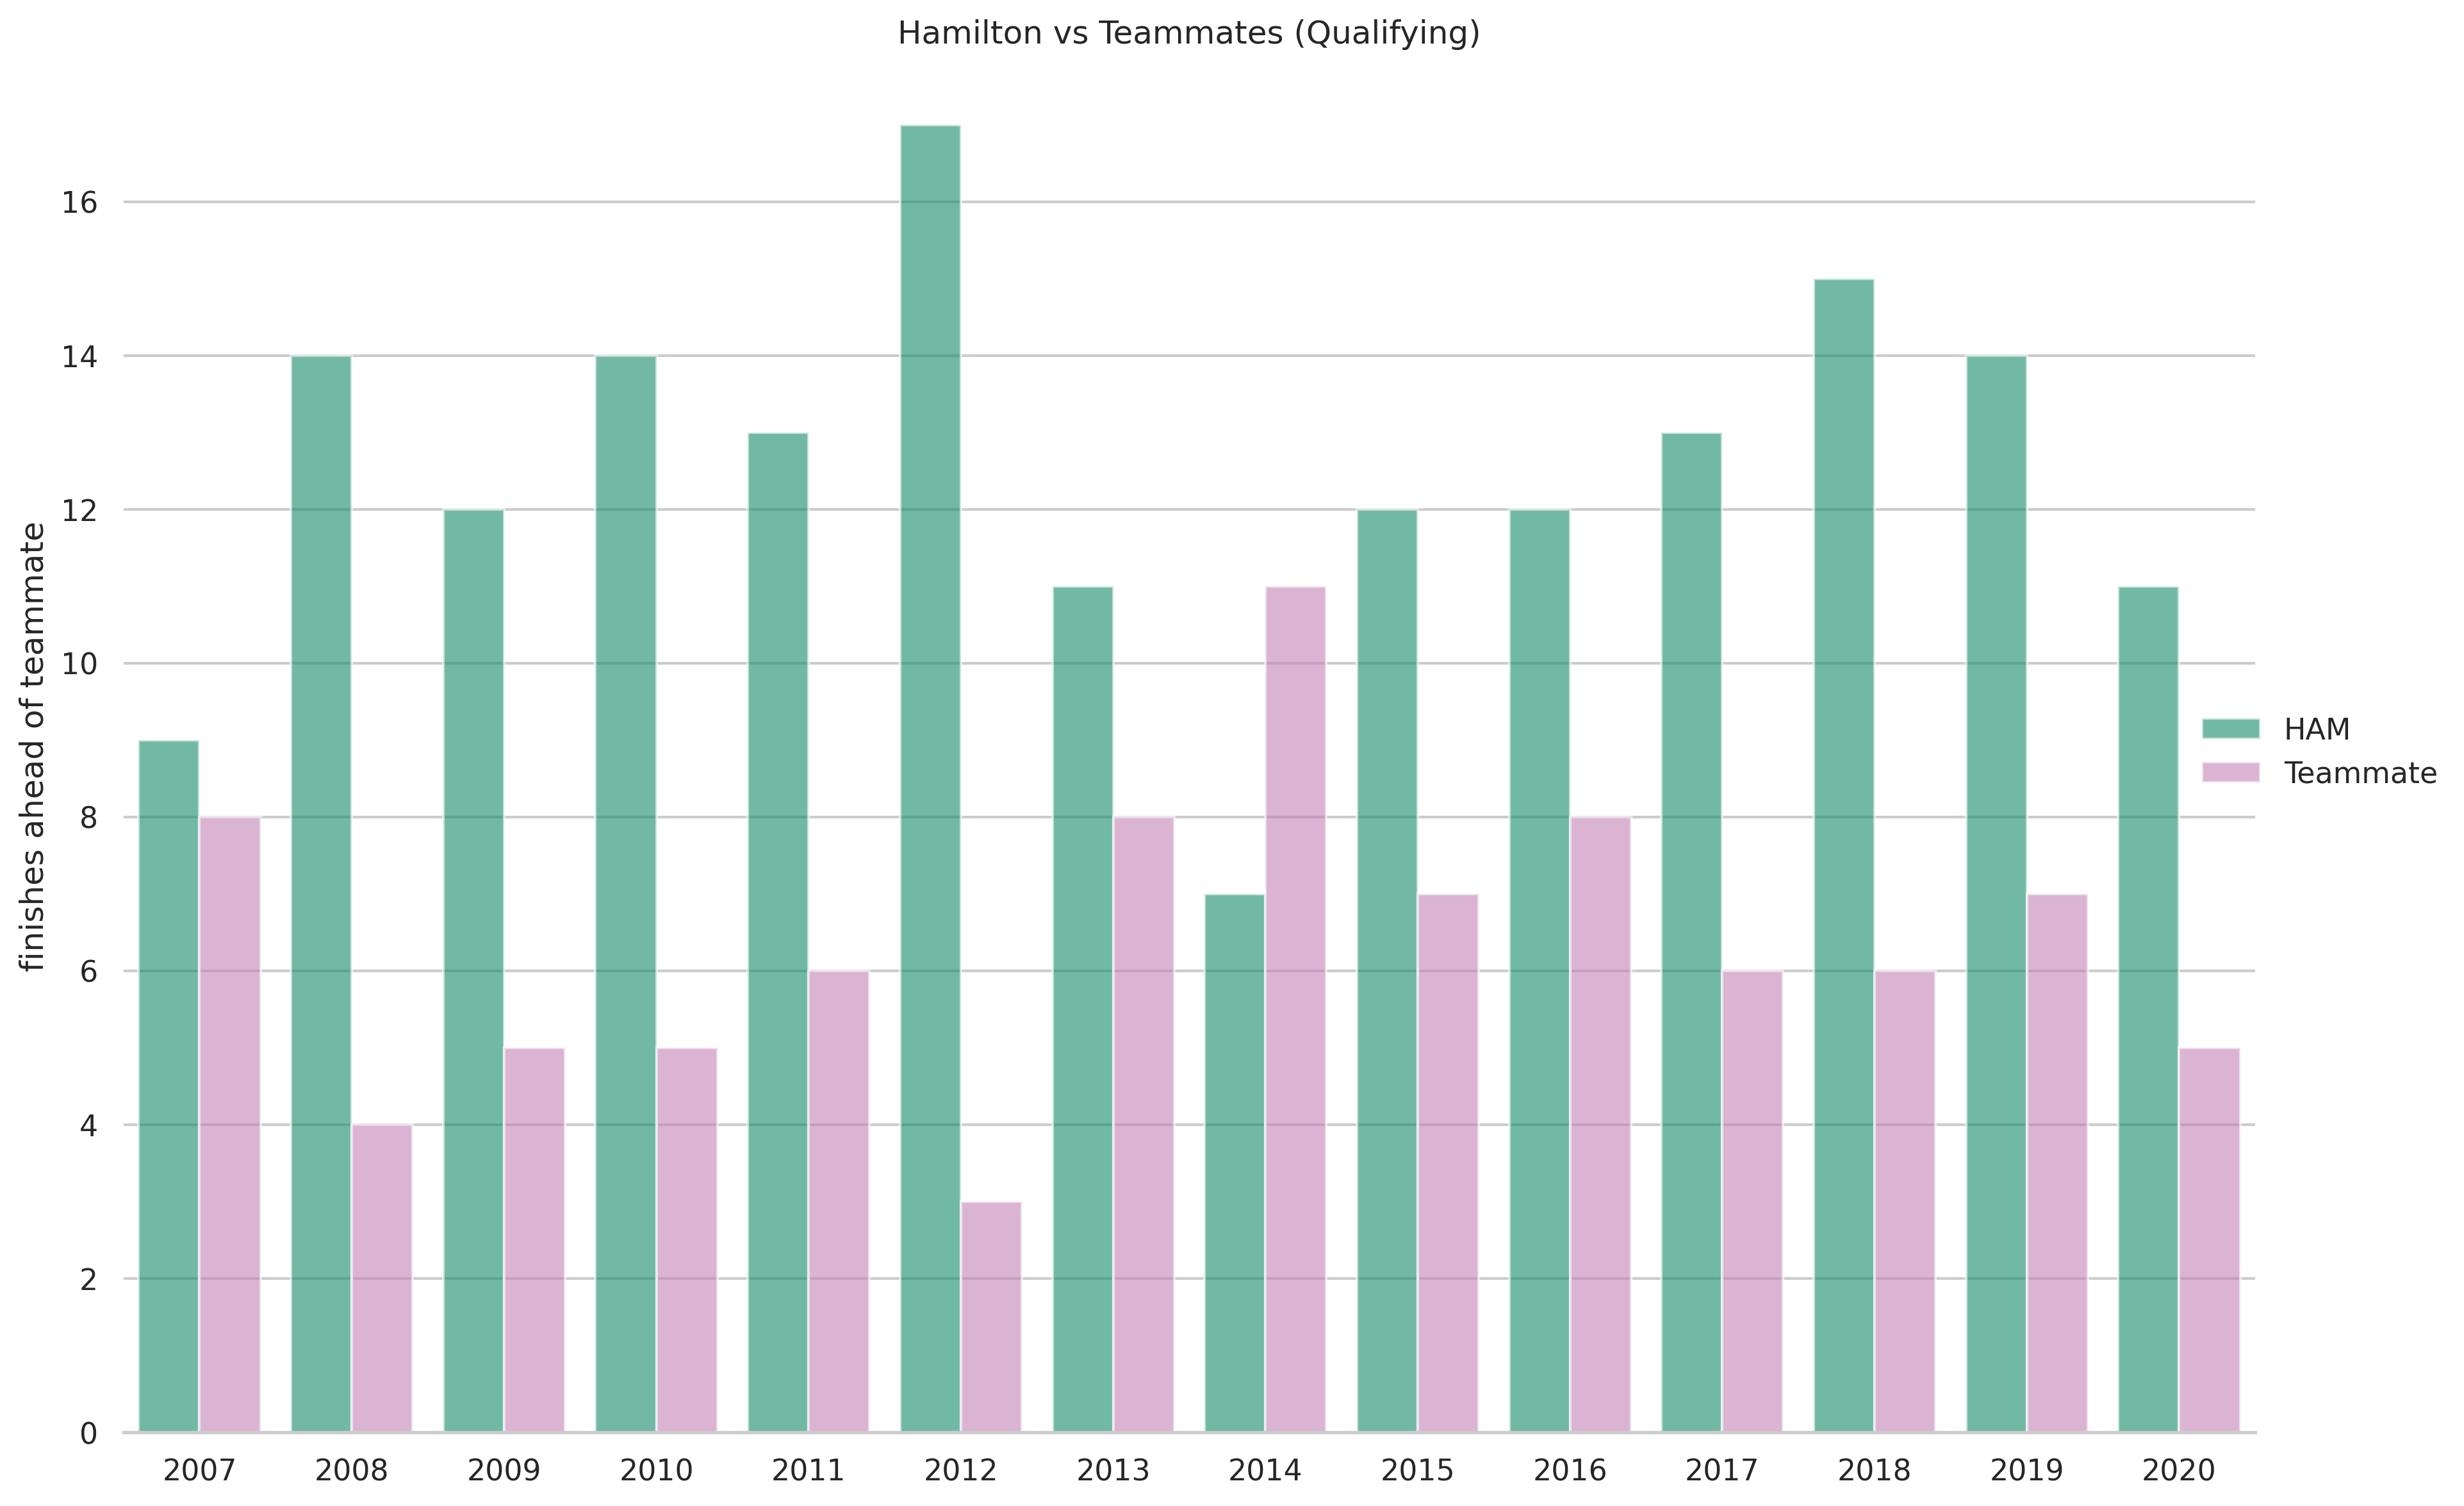

In [55]:
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
matplotlib.rcParams['figure.dpi'] = 300

ham_rivals_year = {}
for key, values in ham_rivals.items():
    for v in values:
        ham_rivals_year[v] = key

def outquali(x):
    if x['code'] == 'HAM':
        rival = ham_rivals_year[x['year']]
    else:
        rival = 'HAM'
    rival_pos = df_rivals[(df_rivals['code'] == rival) & (df_rivals['raceId'] == x['raceId'])]['position']
    return int(x['position']) < int(rival_pos)
    
df_outq = df_rivals[df_rivals['year'] < 2021]

df_outq['outq'] = df_outq.apply(lambda x: outquali(x) ,axis=1)
df_outq['isRival'] = df_outq['code'] != 'HAM'
df_outq = df_outq.groupby(['year', 'code', 'surname', 'constructorRef','isRival'])['outq'].sum().reset_index()



# Draw a nested barplot by species and sex
my_palette = sns.color_palette("colorblind", 10)

g = sns.catplot(
    data=df_outq, kind="bar",
    x="year", y="outq", hue="isRival",
    ci=None, palette= sns.color_palette([my_palette[2], my_palette[4]]),
    alpha=.6, aspect=1.5,height=8,facet_kws={'legend_out': True})

g.despine(left=True)
g.set_axis_labels("", "finishes ahead of teammate")
plt.title('Hamilton vs Teammates (Qualifying)')

# title
new_title = ''
g._legend.set_title(new_title)
new_labels = ['HAM', 'Teammate']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
#plt.savefig("test.png", dpi=300)


Con esto tenemos un primer acercamiento que ya nos permite dar cuenta la superiorirdad de Hamilton en este aspecto con respecto a sus compañeros de equipo. El dominio durante su paso por Mclaren (2007-2013) es contundente, logrando vencer a campeones del mundo como Alonso y Button, así también como al finlandes Heiki Kovalainen 2008-2009.

La temporada 2007, claramente la más apretada en su era Mclaren, fue muy particular en muchos aspectos. 
Para Hamilton fue su temporada debut en la f1 y su oportunidad de brillar con un auto que resultó ser el más competitivo de la parrilla (junto al ferrari).

Esto último me resulta interesante y me gustaría dedicarle algunas líneas : Pocos rookies tuvieron la oportunidad de debutar en un auto contendiente al titulo: Jacques Villeneuve lo hizo en 1996, consiguió el 2do puesto a tres puntos de su compañero Damon Hill y luego logró el titulo venciendo a Schumacher al añó siguiente tras un controvertido final en el GP de Europa en Jerez. Aún así, en su año debut y con esta métrica, terminó significativamente por debajo de Damon. Por otro lado, podemos contar a Alex Albon debutante en 2019 para Toro Rosso que fue "ascendido" a Red Bull, de los más fuertes de la parrilla pero aún no lo suficiente para pelear el titulo, a mediados de ese año. Su caso es mucho menos destacable ya que incluso en 2020 no solo fue dominado por Verstappen en clasificación (de hecho, nunca clasificó por arriba de él) si no que sus resultados en carrera estuvieron por debajo de lo esperado y muy distante de su compañero. Por último, otro caso similar es el de Juan Pablo Montoya que debutó en un fuerte BMW Williams, no lo suficientemente competitivo y muy poco fiable (11 DNFs, solo 3 por choques o idas de pista) pero que le permitió mostrar buenos desempeños. En particular en clasificación termino 6-11 abajo.

![title](jacques.jpg)

Otra particularidad del debut de Hamilton es que en el garage de al lado estaba un tal Fernando Alsono, doble campeón del mundo, también debutante en el equipo.
Al mismo tiempo, para McLaren fue un año oscuro salpicado por el escándalo del ferrari spygate, la dura rivalidad que surgió entre Alonso-Hamilton y los roces entre el español con Ron Denis et al.

Lo que me llama la atención es que en este contexto, no solo Hamilton no decepcionó si no que estuvo a la par de Alonso, considerado uno de los mejores talentos de la formula 1 moderna. Terminaron iguales en puntos y como vemos en la figura anterior, muy apretados en clasificación con un diferencia mínima a favor de Hamilton. Más allá de las controversias de esta temporada, el nivel de competitividad que alcanzó en tan poco tiempo es innegable.

![title](ham_alo.jpg)

La única derrota fue durante la era Mercedes, en la primer temporada de la era híbrida (2014) por Rosberg, tras haberlo vencido en 2013. Llamativamente, la única temporada en la que no logró el título con Mercedes (2016) logró derrotar a Rosberg en clasificación. 

Sin embargo, las comparaciones anteriores nos dan apenas un primer "zoom" para entender el desempeño de Hamilton en clasificación con sus compañeros de equipo. Podría ser que, incluso en temporadas donde la diferencia es amplia entre ambos, el margen con el que uno vence al otro sea muy chico y esto quede opacado por la métrica que adoptamos.

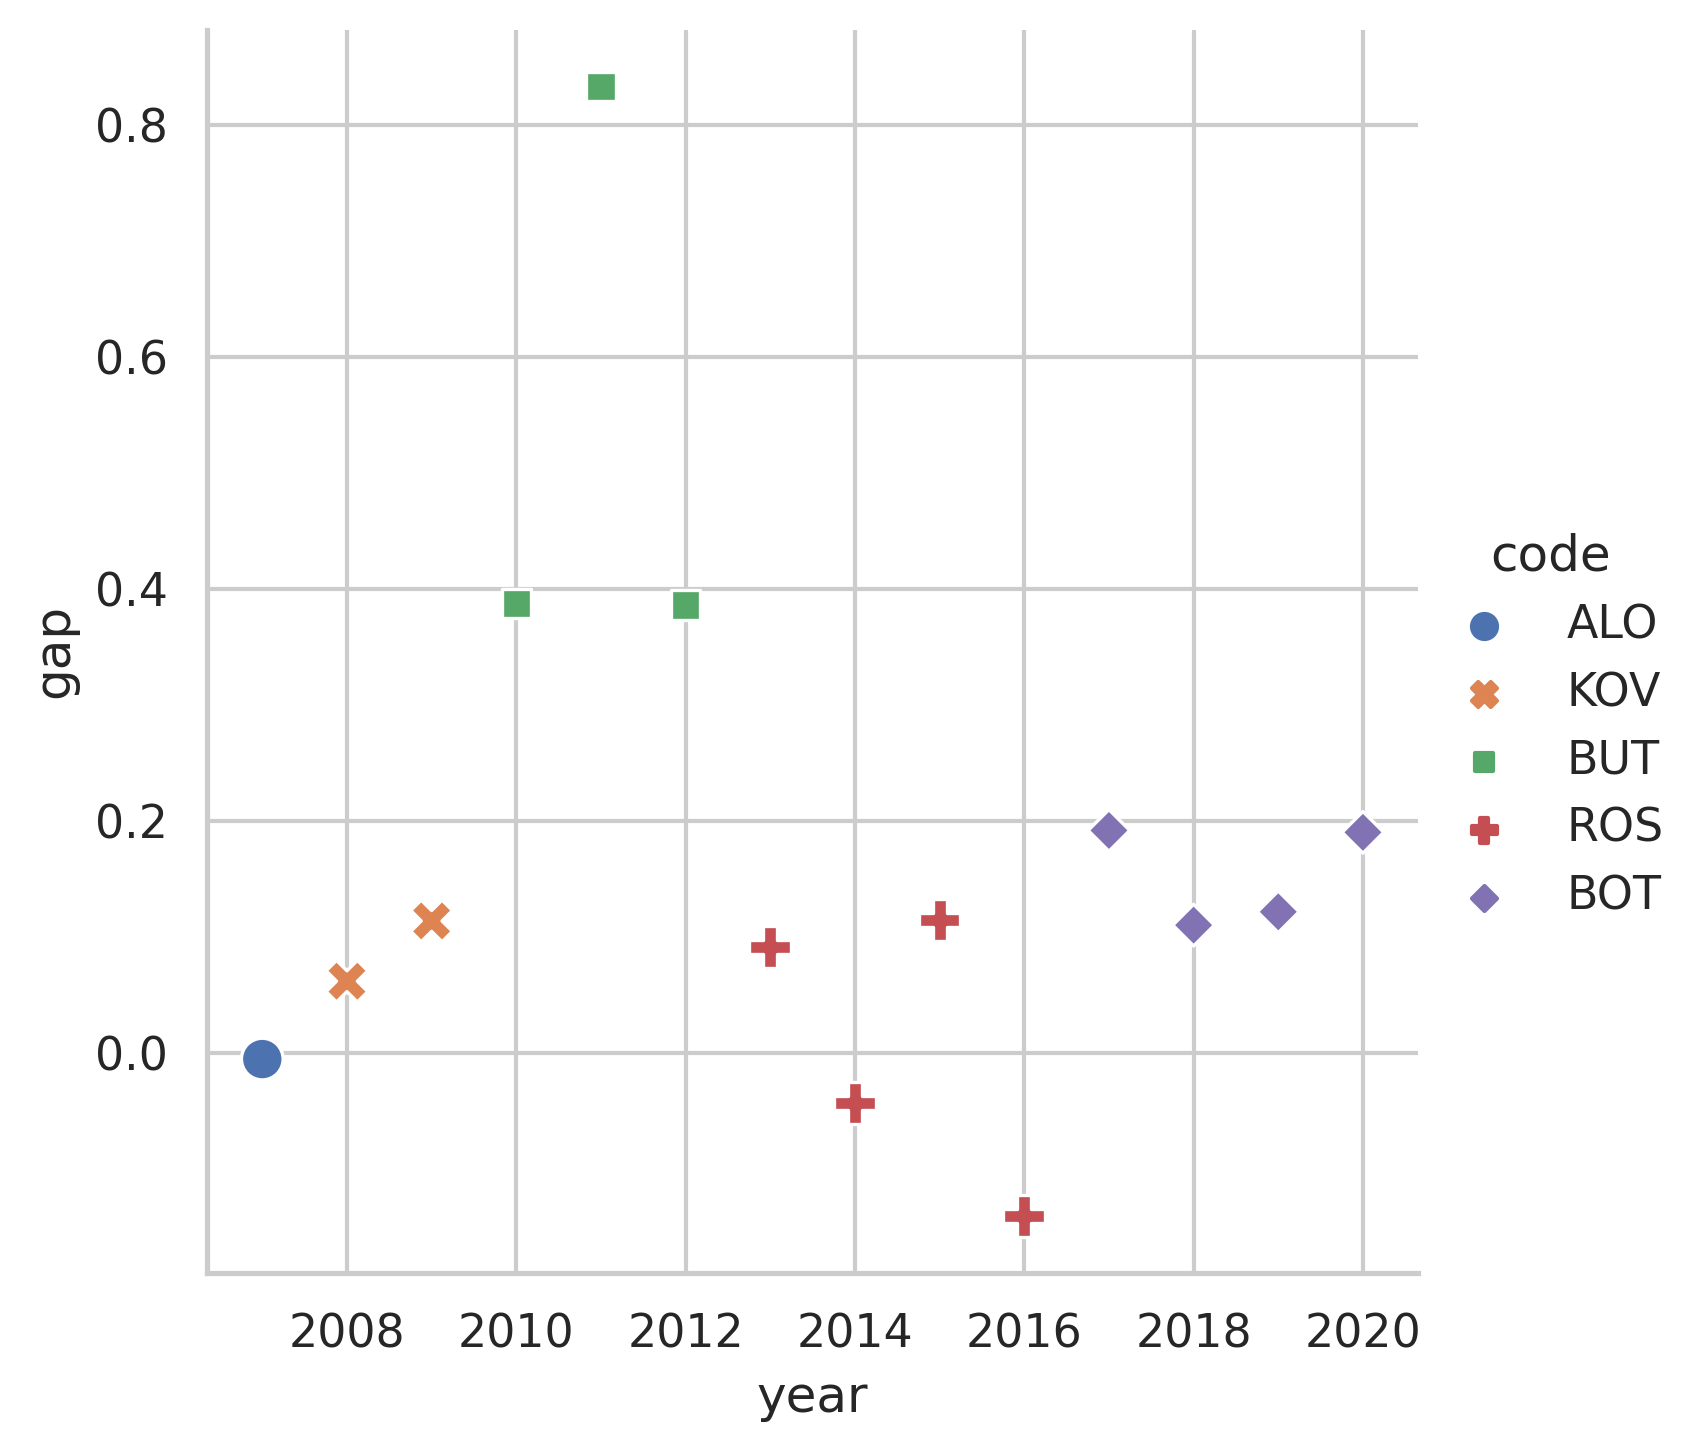

In [56]:
df_rivals = df_rivals.groupby(['year', 'code', 'surname', 'constructorRef'])['best_q'].mean().reset_index()
#df_unique = df_rivals.groupby(['year', 'code'])['best_q'].nunique().reset_index()

def center(x):
    ham = df_rivals[(df_rivals['code'] == 'HAM') & (df_rivals['year'] == x['year'])]
    a = float( x['best_q'] - ham['best_q'])
    return a 

df_rivals['gap'] = df_rivals.apply(lambda x: center(x) ,axis=1)
df_rivals = df_rivals[df_rivals['code'] != 'HAM']

# To check
#dfff = df_rivals[df_rivals['year'] < 2021]
#h = dfff[dfff['code'] == 'HAM']['raceId'].reset_index()
#r = dfff[dfff['code'] != 'HAM']['raceId'].reset_index()
#sum(h['raceId'] -r['raceId'])


sns.relplot(x="year", y="gap", hue="code", style="code",data=df_rivals, s=100, height=5)

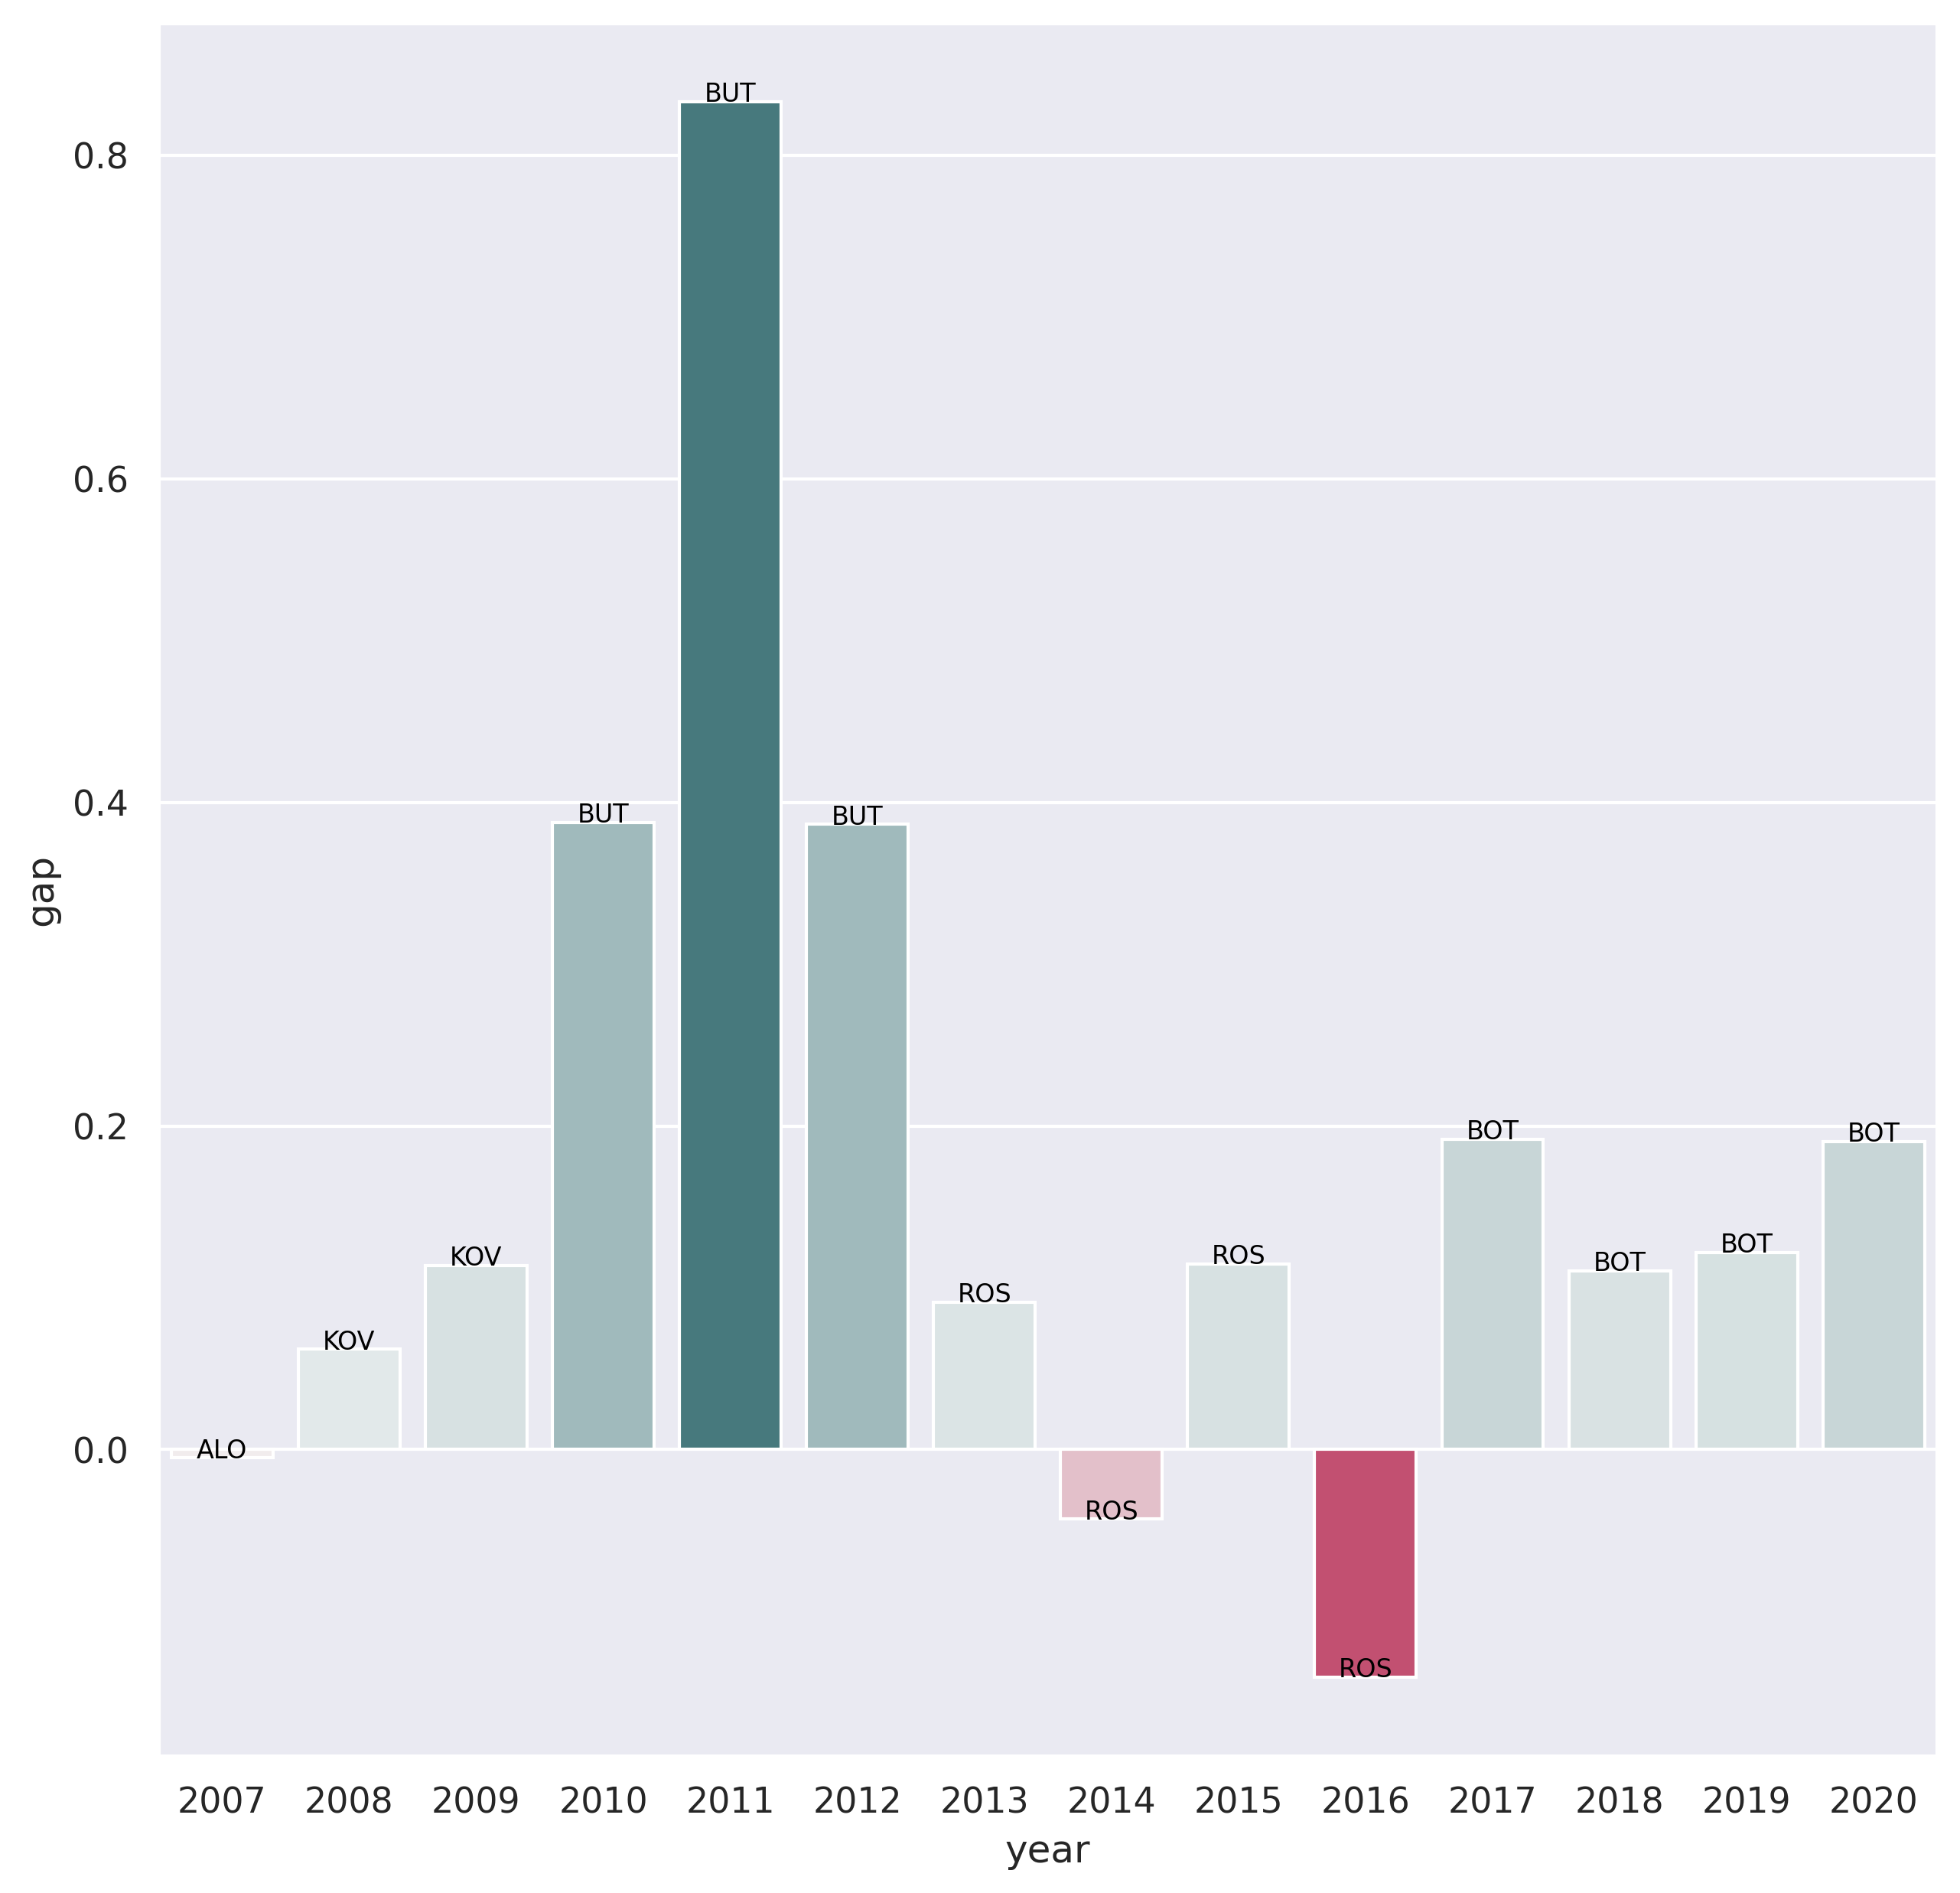

In [62]:
from matplotlib.colors import DivergingNorm
from matplotlib import pyplot as plt

#sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
plt.figure(figsize=(10,10))
norm = DivergingNorm(vmin=df_rivals.gap.min(), vcenter=0, vmax=df_rivals.gap.max())
red_green_pal = sns.diverging_palette(0, 200, n=256, as_cmap=True)
colors = [red_green_pal(norm(c)) for c in df_rivals['gap']]
ax = sns.barplot(x="year", y="gap", palette=colors, ci=None,data=df_rivals)


for index, row in df_rivals.iterrows():
    ax.text(row.year - 2007 ,float(row.gap), row.code, color='black', ha='center', fontsize=8)

plt.show()


Acercandono aún más, podemos ver el "gap" promedio de clasificación contra sus compañeros en todas las instancias en las que ambos participaron durante la temporada. Para tomar el tiempo de referencia en cada clasificación, se considera la mejor vuelta de cada piloto realizada en algún momento durante el total de la sesión (q1, q2 o q3).

ACLARAR LAS CONTRAS

Una vez más vemos lo absurdamente próximos que se encuentran Hamilton y Alsono. Notemos también que en el año de Rosberg campeón (2016) el gap lo favorece (a diferencia de la métrica anterior). Observando los años de rivalidad con Rosberg es interesante destacar la paridad y tener en cuenta que el gap nunca superó los 0.15s, que en términos de clasificación actuales es una diferencia relativamente chica.

La rivalidad con Bottas, que tiene como contuntende vencedor a Hamilton, también arroja un gap que se encuentra dentro de diferencias razonables.

Por último, con este zoom adicional tenemos un visión un poco más completa de lo que ocurrió durante la era Mclaren. La figura confirma lo aplastante que resultó la performance de Ham contra But pero ahora vemos lo, sorprendentemente, cerca que logró colocarse Kov de los tiempos de Ham.



In [63]:
df_rivals

,year,code,surname,constructorRef,best_q,gap
0,2007,ALO,Alonso,mclaren,83.927235,-0.005118
3,2008,KOV,Kovalainen,mclaren,86.061722,0.062000
5,2009,KOV,Kovalainen,mclaren,90.445706,0.113941
6,2010,BUT,Button,mclaren,91.138737,0.387526
8,2011,BUT,Button,mclaren,89.627737,0.833158
10,2012,BUT,Button,mclaren,90.658150,0.386400
13,2013,ROS,Rosberg,mercedes,90.758158,0.091263
15,2014,ROS,Rosberg,mercedes,92.685833,-0.042944
17,2015,ROS,Rosberg,mercedes,89.882947,0.114684
19,2016,ROS,Rosberg,mercedes,86.491350,-0.140600


In [64]:
df_all  = df_qualis[df_qualis['year'] >= 2007]
# filter top10 in wdc
filter_dnfs = (df_all['best_q'] == 300) 
ids_dnfs = df_all[filter_dnfs]['raceId']
filter_dnf = ~(df_all['raceId'].isin(ids_dnfs) | (df_all['raceId'] == 1046))
df_all = df_all[filter_dnf] 
total = df_all.groupby(['year', 'code', 'surname', 'constructorRef'])['best_q'].nunique().reset_index()['best_q']
df_all = df_all.groupby(['year', 'code', 'surname', 'constructorRef'])['best_q'].mean().reset_index()
df_all['total'] = total

ham_all = df_all[df_all['code']  == 'HAM']

def same_as_ham(x):
    a = int(x['total']) == int(ham_all[ham_all['year'] == x['year']]['total'])
    return a

def center(x):
    ham = ham_all[ham_all['year'] == x['year']]
    a = float( x['best_q'] - ham['best_q'])
    return a 

df_all = df_all[df_all.apply(lambda x: same_as_ham(x), axis=1)]
df_all['gap'] = df_all.apply(lambda x: center(x) ,axis=1)
#df_rivals = df_rivals[df_rivals['code'] != 'HAM']
#df_unique[df_unique['year'] == 2010]
df_all[df_all['year'] == 2009]
df_all

,year,code,surname,constructorRef,best_q,total,gap
1,2007,ALO,Alonso,mclaren,84.702333,15,-0.008200
2,2007,BAR,Barrichello,honda,86.359267,15,1.648733
3,2007,BUT,Button,honda,86.197133,15,1.486600
4,2007,COU,Coulthard,red_bull,86.280267,15,1.569733
5,2007,DAV,Davidson,super_aguri,86.508933,15,1.798400
...,...,...,...,...,...,...,...
358,2021,SAI,Sainz,ferrari,74.402000,6,0.523667
359,2021,STR,Stroll,aston_martin,74.883000,6,1.004667
360,2021,TSU,Tsunoda,alphatauri,74.918167,6,1.039833
361,2021,VER,Verstappen,red_bull,73.760167,6,-0.118167


<AxesSubplot:xlabel='year', ylabel='best_q'>

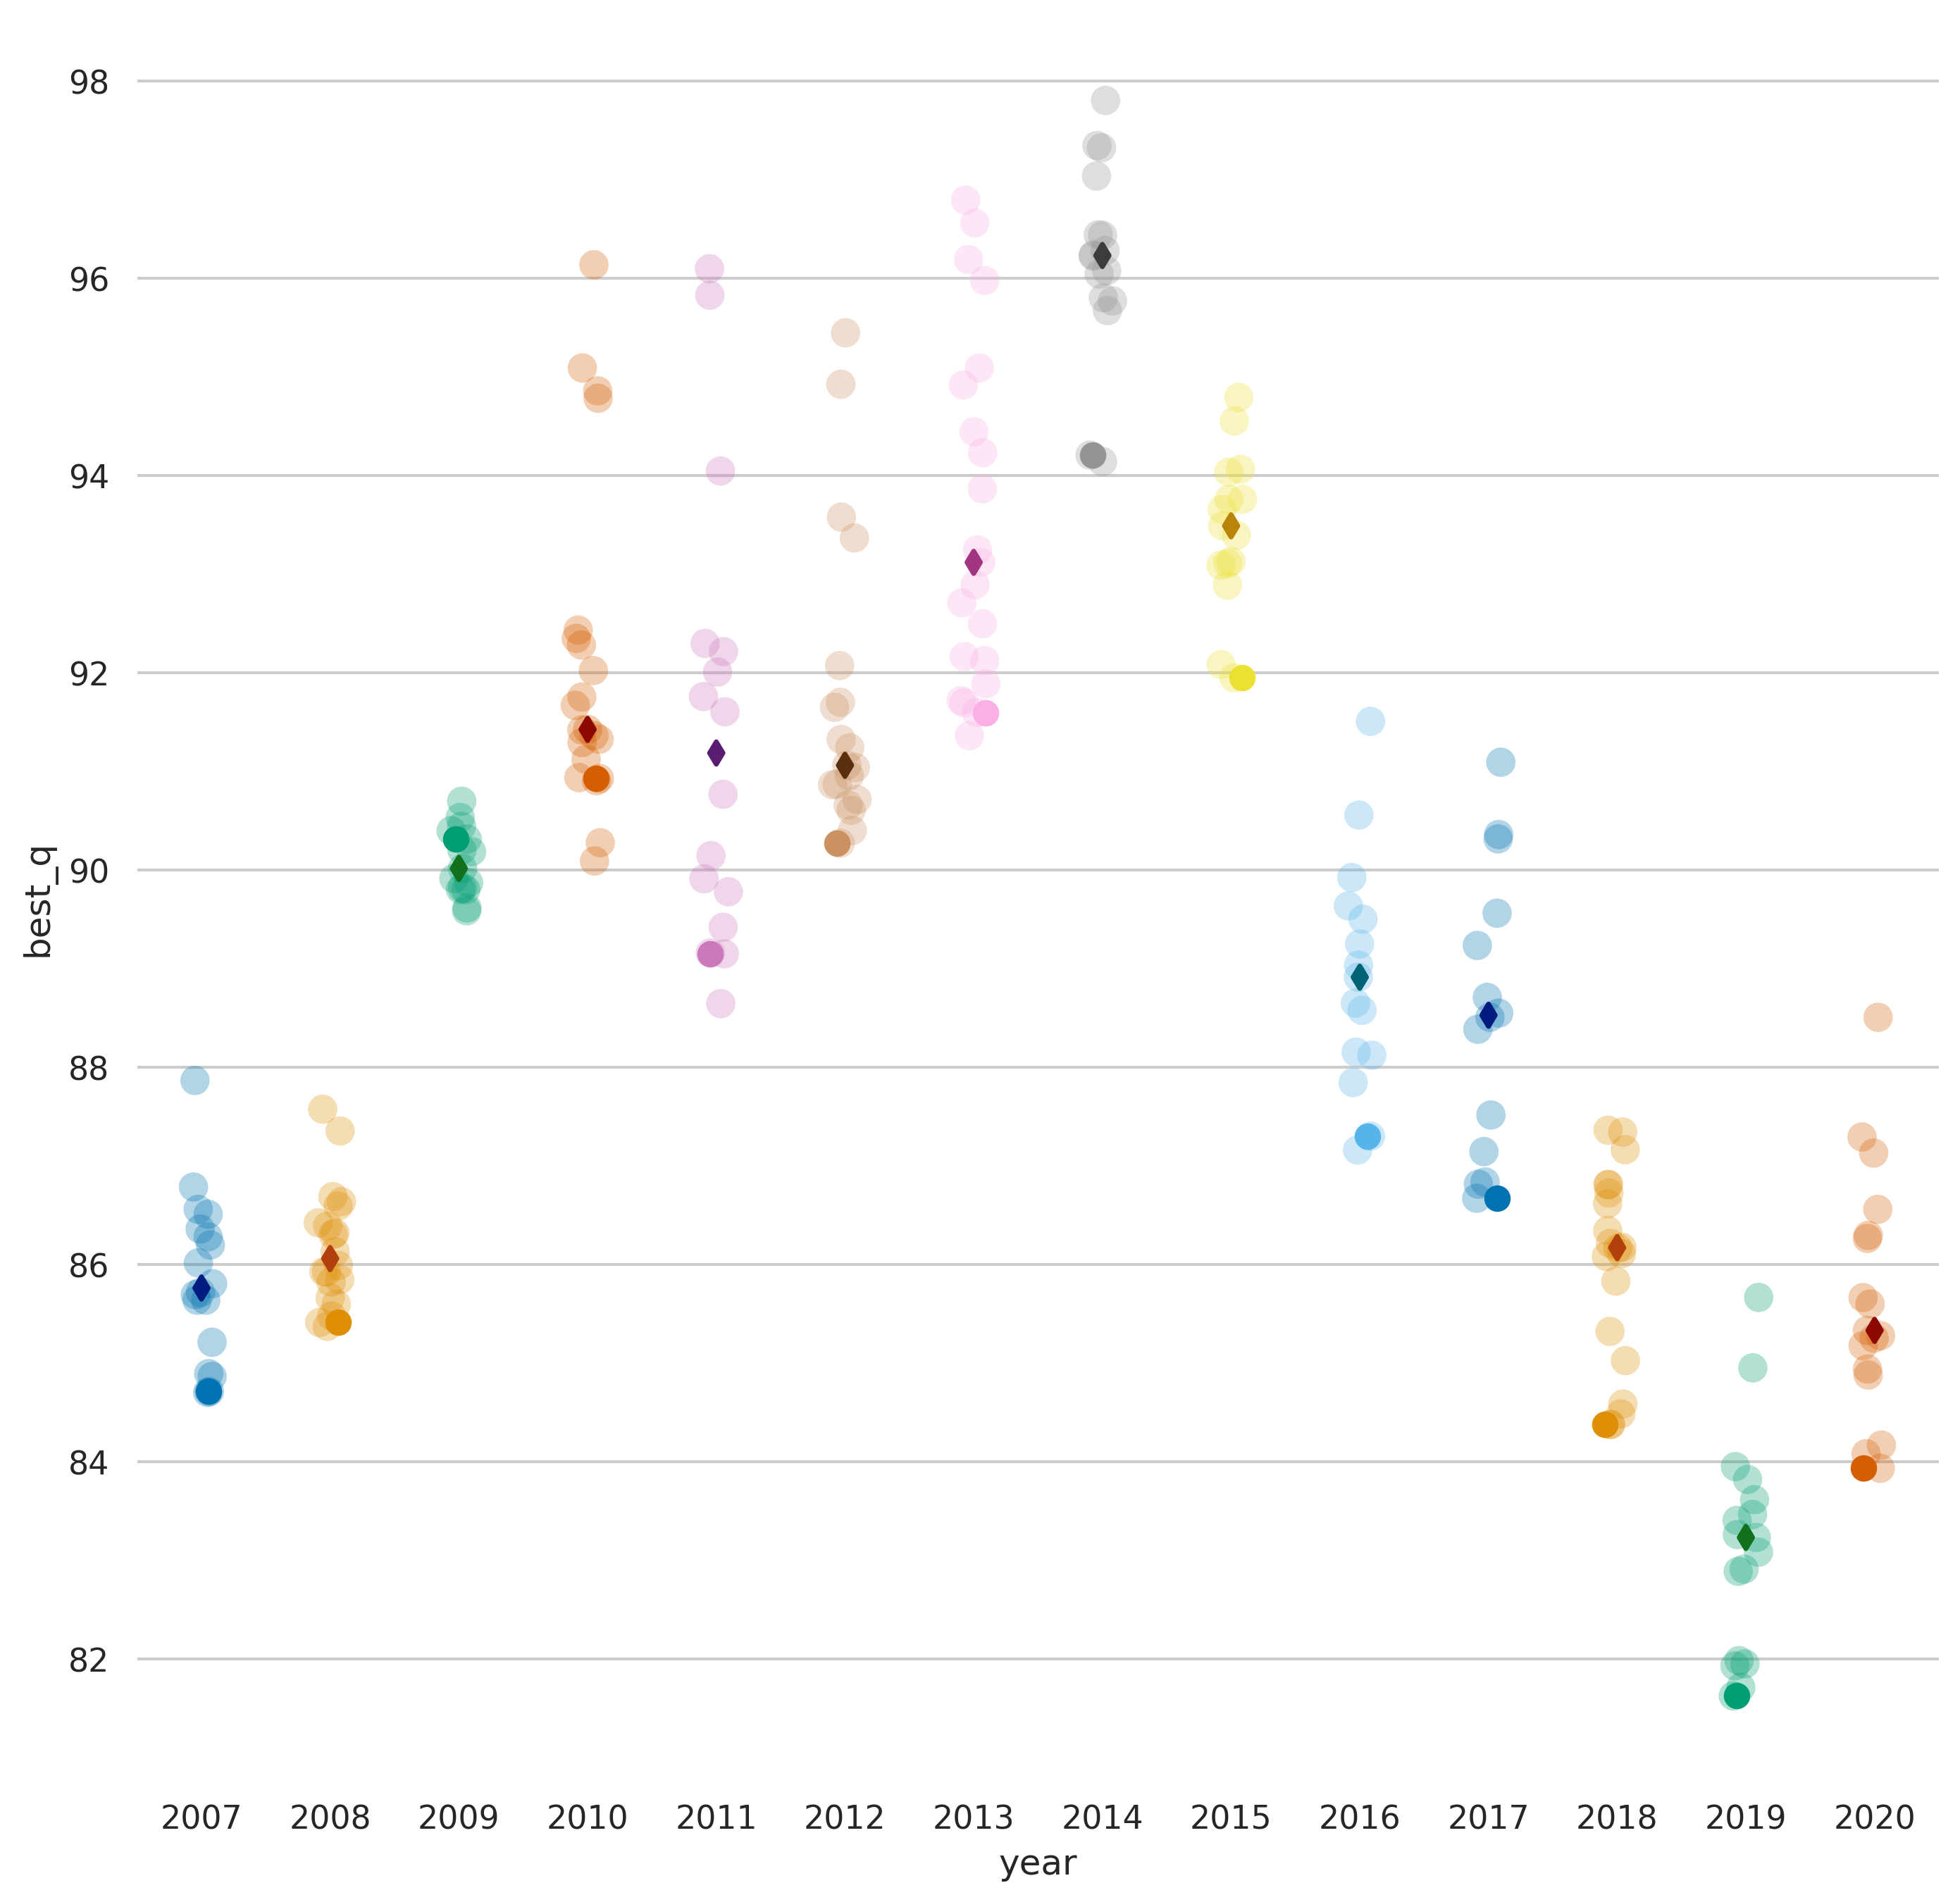

In [65]:
df_all  =  df_all[df_all['year'] < 2021]

sns.set_theme(style="whitegrid")
#sns.set_theme()
ham_points = df_all[df_all['code'] == "HAM"]['best_q']
years = df_all['year'].unique()


# Initialize the figure
f, ax = plt.subplots(figsize=(11,11))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
#ax = sns.boxplot(x="year", y="best_q", data=df_all,)
ax = sns.stripplot(x="year", y="best_q",data=df_all, palette='colorblind',jitter=True, dodge=True, alpha=0.3, zorder=1,size=10)
ax = sns.stripplot(x=years, y=ham_points, dodge=True, palette='colorblind',zorder=1,size=9)
sns.pointplot(x="year", y="best_q", 
              data=df_all, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.8, ci=None, estimator=np.median)


In [66]:
for y in df_all['year'].unique():
    print(df_all[df_all['year'] == y].sort_values(by=['best_q'])[:4])


    year code    surname constructorRef     best_q  total       gap
1   2007  ALO     Alonso        mclaren  84.702333     15 -0.008200
7   2007  HAM   Hamilton        mclaren  84.710533     15  0.000000
14  2007  RAI  Räikkönen        ferrari  84.864000     15  0.153467
12  2007  MAS      Massa        ferrari  84.892200     15  0.181667
    year code     surname constructorRef     best_q  total       gap
39  2008  MAS       Massa        ferrari  85.371375     16 -0.040187
35  2008  HAM    Hamilton        mclaren  85.411562     16  0.000000
37  2008  KOV  Kovalainen        mclaren  85.476062     16  0.064500
42  2008  RAI   Räikkönen        ferrari  85.596562     16  0.185000
    year code      surname constructorRef     best_q  total       gap
52  2009  BAR  Barrichello          brawn  89.586125     16 -0.727187
74  2009  WEB       Webber       red_bull  89.614750     16 -0.698563
55  2009  BUT       Button          brawn  89.800375     16 -0.512938
70  2009  ROS      Rosberg       wi

Lo que podemos tratar de hacer por último es ver para cada temporada como se ubica el tiempo promedio de clasificación de Hamilton con el resto. De particular interés van a ser los años en los que no tuvo el mejor coche, que podría ser desde 2009 hasta 2012.

A simple vista es claro que Hamilton se encuentra consistentemente entre los mejores clasificadores. De hecho, solamente queda fuera del top2 en dos ocasiones: 2009(14) y 2010(4)

2009 es un caso particular, donde McLaren arrancó la temporada con malos resultados luego de haber obtenido el titulo mundial en 2008. De hecho, durante la primera mitad de la temporada no consiguió ningún podio. Eddie Jordan calificó al monoplaza como "posiblemente uno de los peores diseños de su historia". Luego del parate de verano, el equipo logró mejorar significativamente hasta el punto que Hamilton consiguió dos victorias (Hungria y Singapur). Finalmente McLaren termina en tercer puesto. 
Es interesante tambien remarcar que esta temporada fue la que menos disperción tuvo en tiempos de clasificación, siendo así que a pesar de que Hamilton se encuentre detrás de la mediana, el gap contra Button (3) es cercano a 0.512s. En 2011(2) Hamilton queda a 0.5 de Vettel(1).

A partir del 2014, comienzo de la era hibrida, hasta 2016 el gráfico no agrega nada nuevo en cuanto a la paridad con Rosberg pero sí nos permite ver la marcada distancia que lograron marcar los hombres de Mercedes con el resto de los equipos. Diferencias entre 1 y 2 segundos con otros equipos grandes como Ferrari y Red Bull que es un montón.
Luego desde 2017 Hamilton estos últimos comienzan a achicar la brecha pero Hamilton termina siempre con el mejor tiempo promedio.

Como vemos, aún cuando no tiene un coche campeón, Hamilton se desempeña consistentemente como uno de los mejores clasificadores (excepto en 2009).

Cuando tiene un coche campeón (era Mercedes) solo es derrotado por Rosberg en dos ocasiones (con la diferencia más contundente cercana a 1 decima y media, o bien termina segundo (2007,2008) pero por tan solo 8milesimas y 4centésimas (alo, massa)




In [ ]:

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 8))

ax = sns.violinplot(x="year", y="best_q", data=df_all,palette="Set3", bw=.2, cut=1, linewidth=1)
# Draw a violinplot with a narrower bandwidth than the default

# Finalize the figure
ax.set(ylim=(80, 100))
sns.despine(left=True, bottom=True)